El objetivo de esta práctica es mostrar un ejemplo de implementación de LDA (Lineal Discrimination Analysis). LDA es un método de reducción de dimensionalidad pero, al contrario que otros como PCA, que no asume nada en cuanto a los datos de entrada, en LDA la información está etiquetada, ésto es, se sabe a priori a qué clase debería pertenecer cada dato. En este sentido, LDA busca maximizar la separación entre clases en el proceso de reducción de dimensionalidad.

Vamos a aplicar tanto LDA como PCA al mismo conjunto de datos para comprobar la diferencia. Para ello, necesitamos un dataset donde los datos estén etiquetados, es decir, las variables independientes vengan acompañadas por la variable dependiente esperada y, por tanto,  podamos establecer  a priori las clases que necesitamos. En este caso usaremos el dataset *vehicle*, incluida en sklearn, que contiene una serie de características ya extraídas de imágenes de vehículos que definen su silueta, así como el tipo de vehículo del que se trata en cada caso, que puede ser OPEL, SAAB, BUS, VAN (4 clases).

A continuación se incluye el código para el que desee ejecutarlo paso a paso.

In [20]:
#cargar todas las librerías necesarias, incluyendo matplotlib para las visualizaciones y sklearn para LDA y PCA
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import seaborn as sns
from sklearn import datasets

# Cargar el dataset desde la URL proporcionada
url = 'https://github.com/crisurdiales/DataMining4SmartCities/raw/main/vehicle.csv'
vehicle = pd.read_csv(url)

# Mostrar las primeras filas del DataFrame para verificar la carga correcta
print(vehicle.head())

   Compactness   Circularity   Distance_circularity   Radius_ratio  \
0           95            48                     83            178   
1           91            41                     84            141   
2          104            50                    106            209   
3           93            41                     82            159   
4           85            44                     70            205   

    Praxis_aspect_ratio   Max_length_aspect_ratio   Scatter_ratio  \
0                    72                        10             162   
1                    57                         9             149   
2                    66                        10             207   
3                    63                         9             144   
4                   103                        52             149   

    Elongatedness   Praxis_rectangular   Length_rectangular   Major_variance  \
0              42                   20                  159              176   
1   

Observese que los nombres de las columnas tienen espacios alrededor, e.g. " Minor_skewness", que habría que eliminar para facilitar su selección. Eliminemos ese espacio y comprobemos los nombres de las columnas.

In [21]:
vehicle.columns = vehicle.columns.str.strip()
print(vehicle.columns)

Index(['Compactness', 'Circularity', 'Distance_circularity', 'Radius_ratio',
       'Praxis_aspect_ratio', 'Max_length_aspect_ratio', 'Scatter_ratio',
       'Elongatedness', 'Praxis_rectangular', 'Length_rectangular',
       'Major_variance', 'Minor_variance', 'Gyration_radius', 'Major_skewness',
       'Minor_skewness', 'Minor_kurtosis', 'Major_kurtosis', 'Hollows_ratio',
       'Class'],
      dtype='object')


Ahora pasamos a incluir en X las variables independientes y en Y la variable dependiente (clase) para hacer nuestro análisis. Además, vamos a escalar X para que todas las variables se muevan en el mismo rango de pesos.

In [22]:
# Separar características (X) y etiquetas (y)
X = vehicle.drop(columns=['Class'])  # características
y = vehicle['Class']  # etiquetas

# Normalizar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


A continuación, efectuamos el análisis LDA y PCA. Primero efectuaremos el PCA, para obtener el número de componentes que explique un porcentaje aceptable de varianza. Vamos a dibujar las dos primeras componentes de los datos proyectados sobre un plano.

[0.52378531 0.69171935 0.79719604 0.86287318 0.91343532 0.94306737
 0.96284706 0.97511342 0.98389396 0.98896691 0.99246237 0.99489828
 0.99684527 0.99803108 0.99891947 0.99963577 0.99997986 1.        ]


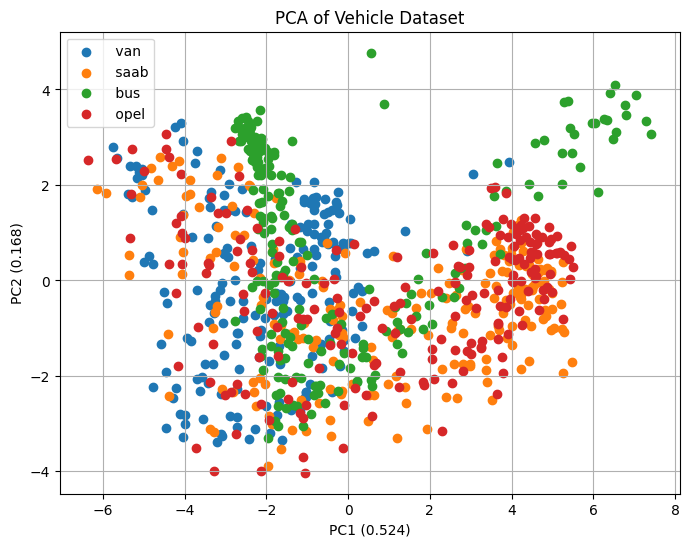

In [ ]:
# Aplicar PCA
#pca = PCA(n_components=2)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Obtener las proporciones de varianza explicada por PCA
cumulative_variance_ratio_pca = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance_ratio_pca)  #con 3 componentes explicamos casi el 80% de la varianza
# Visualizar PCA
plt.figure(figsize=(8, 6))
for label in y.unique():
    plt.scatter(X_pca[y == label, 0], X_pca[y == label, 1], label=label)

plt.xlabel(f'PC1 ({prop_pca[0]:.3f})')
plt.ylabel(f'PC2 ({prop_pca[1]:.3f})')
plt.title('PCA of Vehicle Dataset')
plt.legend()
plt.grid(True)

[0.52709885 0.96767342 1.        ]


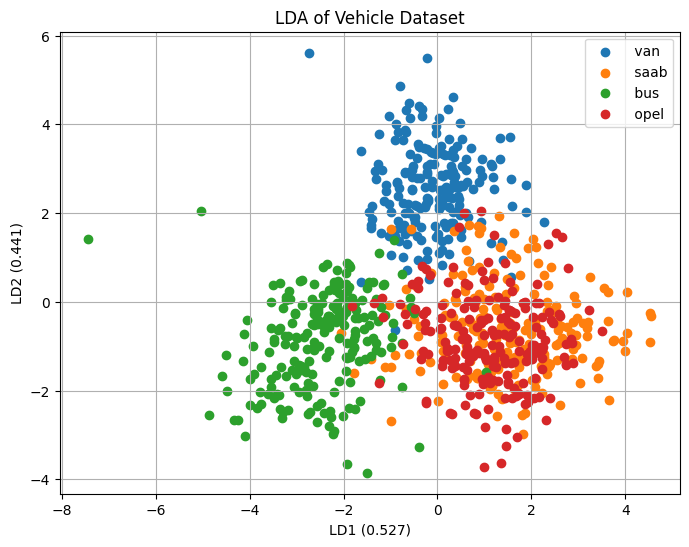

In [ ]:
# Aplicar LDA
lda = LDA(n_components=3)
X_lda = lda.fit_transform(X_scaled, y)

# Obtener las proporciones de varianza explicada por LDA
prop_lda = lda.explained_variance_ratio_
cumulative_variance_ratio_lda = np.cumsum(prop_lda)
print(cumulative_variance_ratio_lda)

# Visualizar LDA
plt.figure(figsize=(8, 6))
for label in y.unique():
    plt.scatter(X_lda[y == label, 0], X_lda[y == label, 1], label=label)

plt.xlabel(f'LD1 ({prop_lda[0]:.3f})')
plt.ylabel(f'LD2 ({prop_lda[1]:.3f})')
plt.title('LDA of Vehicle Dataset')
plt.legend()
plt.grid(True)

Por último, vamos a extraer un modelo de regresión lineal de los datos no reducidos, los tratados con PCA y los tratados con LDA para comparar su bondad. Se puede observar que con 3 componentes lda se explica la varianza completa, mientras que PCA sólo explicaría el 80% de la varianza, por lo que cabe esperar que el modelo entrenado con LDA funcione igual que el original y mejor qye OCA. Hay que considerar, no obstante, que LDA funciona de forma ajustada a la variable dependiente, por lo que si los datos no están etiquetados a priori, no se puede emplear.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

#paso las variables categoricas en y a numericas para hacer la prediccion
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Ajustar un modelo de regresión lineal con datos sin reducir
lm_full = LinearRegression() #usaremos este para comparar con el reducido
lm_full.fit(X_scaled, y_encoded) #aqui usamos la estructura original

# Ajustar un modelo de regresión lineal con los componentes principales, quedandonos solo con los 4 primeros
lm_pca = LinearRegression()
lm_pca.fit(X_pca[:, :3], y_encoded) #prediccion de y, que es la variable dependiente

#Ajustar por ultimo la regresión con LDA (ya tiene 3 componentes)
lm_lda = LinearRegression()
lm_lda.fit(X_lda, y_encoded)

#calculemos finalmente el R2Score de los tres modelos. Cuanto mas cercano a 1, mejor el modelo

r2_full = lm_full.score(X_scaled, y_encoded)
r2_pca = lm_pca.score(X_pca[:, :3], y_encoded)
r2_lda = lm_lda.score(X_lda, y_encoded)

print(f"R² (lm_full): {r2_full:.4f}")
print(f"R² (lm_pca): {r2_pca:.4f}")
print(f"R² (lm_lda): {r2_lda:.4f}")

R² (lm_full): 0.6549
R² (lm_pca): 0.0834
R² (lm_lda): 0.6549


Observese también que los valores de R2 no son particularmente altos en ningún caso, pero esto no se debe a la reducción, sino a que la Regresión Lineal no es capaz de ajustarse a dichos datos.